In [2]:
import pandas as pd
import numpy as np
import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, Rescaling, BatchNormalization
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
sns.set_style()
%matplotlib inline


In [9]:
# Making data sets from images that are in folders named as their class_label
column_labels = ['blouse', 'dhoti_pants', 'dupattas', 'gowns', 'kurta_men', 'leggings_and_salwars', 'lehenga', 'mojaris_men', 'mojaris_women', 'nehru_jackets', 'palazzos', 'petticoats', 'sherwanis', 'saree', 'women_kurta']
train_dataset = image_dataset_from_directory(
    'data/interim/train_w_labels',
    labels='inferred',
    color_mode='grayscale',
    batch_size=256,
    image_size=(70,70),
    shuffle=True,
    seed=None,
    validation_split=None,
    crop_to_aspect_ratio=False,
    class_names=column_labels)

Found 91166 files belonging to 15 classes.


In [10]:
val_dataset = image_dataset_from_directory(
    '/data/interim/val_w_labels',
    labels='inferred',
    color_mode='grayscale',
    batch_size=256,
    image_size=(70,70),
    shuffle=True,
    seed=None,
    validation_split=None,
    crop_to_aspect_ratio=False,
    class_names=column_labels)

Found 7500 files belonging to 15 classes.


In [11]:
test_dataset = image_dataset_from_directory(
    'data/interim/test_w_labels',
    labels='inferred',
    color_mode='grayscale',
    batch_size=256,
    image_size=(70,70),
    shuffle=False,
    seed=None,
    validation_split=None,
    crop_to_aspect_ratio=False,
    class_names=column_labels)

Found 7500 files belonging to 15 classes.


In [12]:
# Normalizing images
normalization_layer = layers.Rescaling(1./255)
train_ds_norm = train_dataset.map(lambda x, y: (normalization_layer(x), y))
test_ds_norm = test_dataset.map(lambda x, y: (normalization_layer(x), y))
val_ds_norm = test_dataset.map(lambda x, y: (normalization_layer(x), y))

In [13]:
# Setting up model
img_width, img_height = 70, 70
epochs = 1000
batch_size = 256
n_classes = 15
input_shape= (img_width, img_height, 1)

In [14]:

# Keras model
model = Sequential()
model.add(Conv2D(32, (3,3), activation='relu', input_shape=input_shape, padding='same'))
model.add(layers.BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.2))

model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.3))

model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.4))

model.add(Flatten())

model.add(Dense(140, activation='relu'))

model.add(Dropout(0.45))

model.add(Dense(n_classes, activation='softmax'))

model.compile(loss='SparseCategoricalCrossentropy', optimizer='adam', metrics=['accuracy'])

In [15]:
# Saving the weights for the lowest loss value
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath='modesl/final_model.keras',
        save_best_only=True,
        monitor='val_loss'
    )]

In [16]:
# Running model
history = model.fit(
    x=train_ds_norm,
    y=None,
    validation_data= val_ds_norm,
    epochs=epochs,
    verbose="auto",
    callbacks=callbacks,
    validation_split=0.0,
    shuffle=True,
    validation_freq=1,
    batch_size = batch_size
    )

Epoch 1/1000
357/357 [==============================] - 38s 66ms/step - loss: 1.6482 - accuracy: 0.4794 - val_loss: 2.2642 - val_accuracy: 0.2899
Epoch 2/1000
357/357 [==============================] - 23s 63ms/step - loss: 1.1158 - accuracy: 0.6380 - val_loss: 0.9321 - val_accuracy: 0.6811
Epoch 3/1000
357/357 [==============================] - 23s 63ms/step - loss: 0.9767 - accuracy: 0.6824 - val_loss: 0.8065 - val_accuracy: 0.7296
Epoch 4/1000
357/357 [==============================] - 23s 64ms/step - loss: 0.8927 - accuracy: 0.7114 - val_loss: 0.7304 - val_accuracy: 0.7527
Epoch 5/1000
357/357 [==============================] - 23s 62ms/step - loss: 0.8302 - accuracy: 0.7314 - val_loss: 0.8410 - val_accuracy: 0.7080
Epoch 6/1000
357/357 [==============================] - 23s 63ms/step - loss: 0.7872 - accuracy: 0.7464 - val_loss: 0.6864 - val_accuracy: 0.7685
Epoch 7/1000
357/357 [==============================] - 23s 64ms/step - loss: 0.7472 - accuracy: 0.7589 - val_loss: 0.6565 -

In [17]:
# Loading the best weights for this model
model.load_weights('models/final_model.keras')

In [18]:
loss, acc = model.evaluate(test_ds_norm, y=None, verbose=2)

30/30 - 1s - loss: 0.4315 - accuracy: 0.8623 - 1s/epoch - 41ms/step


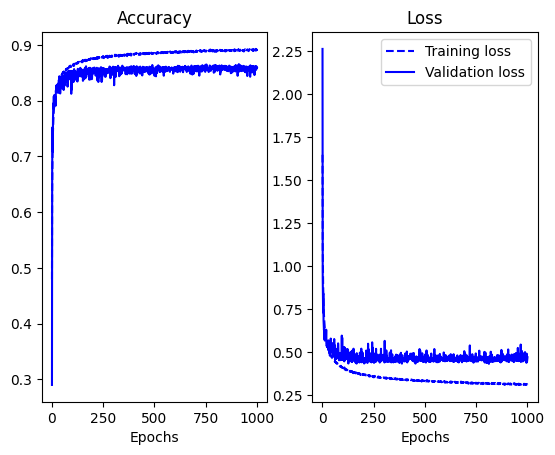

In [20]:
# Plotting the accuracy and loss values for both the training and validation sets
fig, (ax1,ax2) = plt.subplots(1,2)
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)

ax1.plot(epochs, accuracy, 'b--', label='Training accuracy')
ax1.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
ax2.plot(epochs, loss, 'b--', label='Training loss')
ax2.plot(epochs, val_loss, 'b',label='Validation loss')
ax1.set_title('Accuracy')
ax2.set_title('Loss')
ax1.set_xlabel('Epochs')
ax2.set_xlabel('Epochs')

plt.legend()
plt.show()

In [ ]:
# Plotting the accuracy and loss values for both the training and validation sets
test_dataset = test_ds_norm.map(lambda x, y: (255*x, y))

In [ ]:
# Getting the images (x_test) and true categories (y_true) from test data set
y_true = []
x_test = []
for x, y in test_dataset:
    y = y.numpy()
    y_true.append(y)
    x_test.append(x)

In [ ]:
# Unpacking nested list into 1-D list
y_true = [item for sublist in y_true for item in sublist]
x_test = [item for sublist in x_test for item in sublist]

In [ ]:
# Predicting labels from model
y_pred = model.predict(
    test_ds_norm,
    batch_size=None,
    verbose="auto",
    steps=None,
    callbacks=None,
    max_queue_size=10,
    workers=1,
    use_multiprocessing=False,
    )

59/59 [==============================] - 26s 444ms/step


In [ ]:
# Since softmax gives probabilities of labels being correct, to get the most likely label,
# must take maximum probability for each label
y_pred = y_pred.argmax(axis=1)

In [ ]:
# Calculating metrics
ps = precision_score(y_true, y_pred, average='macro')*100
rs = recall_score(y_true, y_pred, average='macro')*100
f1 = f1_score(y_true, y_pred, average='macro')*100

print(f'Precision: {ps:.2f}')
print(f'Recall: {rs:.2f}')
print(f'F1 Score: {f1:.2f}')

Precision: 85.98
Recall: 84.68
F1 Score: 84.61


In [ ]:
# Making a dictionary to take the numerical output and translate it to the class label
label_dict = {0:'blouse', 1:'dhoti_pants', 2:'dupattas', 3:'gowns', 4:'kurta_men', 5:'leggings_and_salwars', 6:'lehenga',
          7:'mojaris_men', 8:'mojaris_women', 9:'nehru_jackets', 10:'palazzos', 11:'petticoats', 12:'sherwanis', 13:'saree',
           14:'women_kurta'}

In [ ]:
# Squeezing the np array so that its shape is (70, 70) instead of (70, 70, 1), which is required for Image.fromarray
def tensor_to_image(tensor):
    tensor = np.array(tensor, dtype=np.uint8)
    tensor = np.squeeze(tensor, axis=2)
    return Image.fromarray(tensor)

## Showing some images and their true and predicted labels.

True label: blouse. Predicted label: blouse


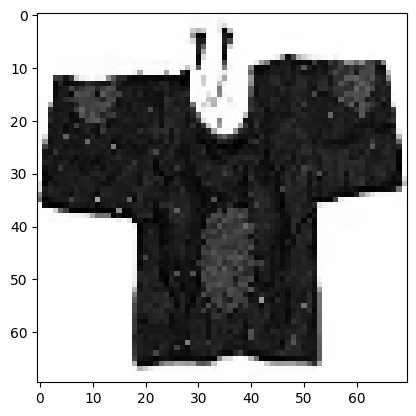

In [ ]:
img = tensor_to_image(x_test[1])
plt.imshow(img, cmap='gray')
print(f'True label: {label_dict[y_true[1]]}. Predicted label: {label_dict[y_pred[1]]}')


True label: sherwanis. Predicted label: sherwanis


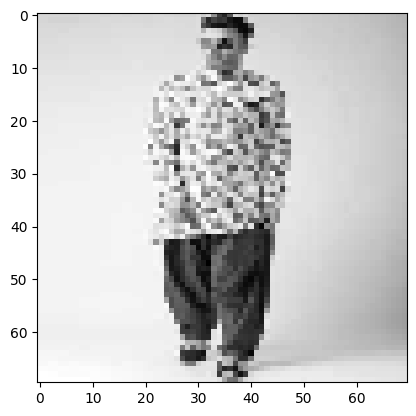

In [ ]:
img = tensor_to_image(x_test[6500])
plt.imshow(img, cmap='gray')
print(f'True label: {label_dict[y_true[6500]]}. Predicted label: {label_dict[y_pred[6500]]}')

True label: dupattas. Predicted label: women_kurta


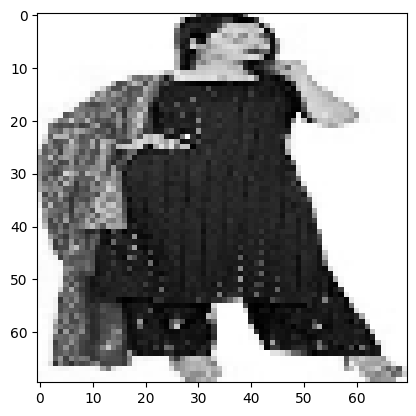

In [ ]:
img = tensor_to_image(x_test[1120])
plt.imshow(img, cmap='gray')
print(f'True label: {label_dict[y_true[1120]]}. Predicted label: {label_dict[y_pred[1120]]}')

## The woman above is wearing a kurta and a dupatta

True label: dupattas. Predicted label: dupattas


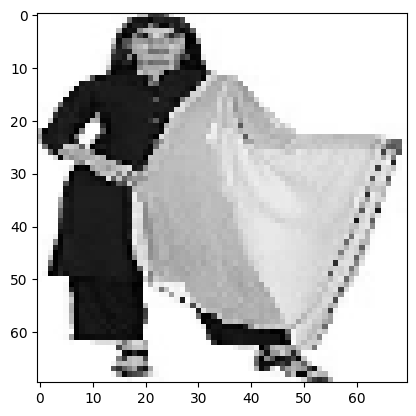

In [ ]:
img = tensor_to_image(x_test[1300])
plt.imshow(img, cmap='gray')
print(f'True label: {label_dict[y_true[1300]]}. Predicted label: {label_dict[y_pred[1300]]}')

True label: women_kurta. Predicted label: women_kurta


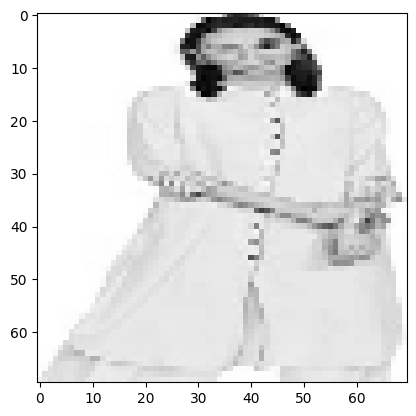

In [ ]:
img = tensor_to_image(x_test[7000])
plt.imshow(img, cmap='gray')
print(f'True label: {label_dict[y_true[7000]]}. Predicted label: {label_dict[y_pred[7000]]}')


True label: saree. Predicted label: saree


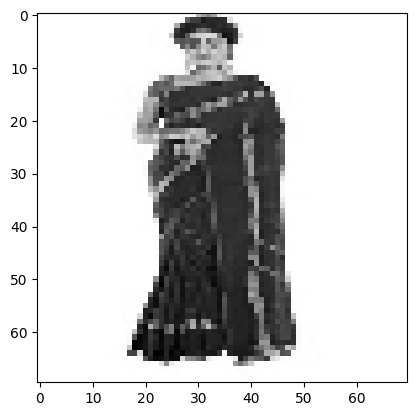

In [ ]:
img = tensor_to_image(x_test[6000])
plt.imshow(img, cmap='gray')
print(f'True label: {label_dict[y_true[6000]]}. Predicted label: {label_dict[y_pred[6000]]}')

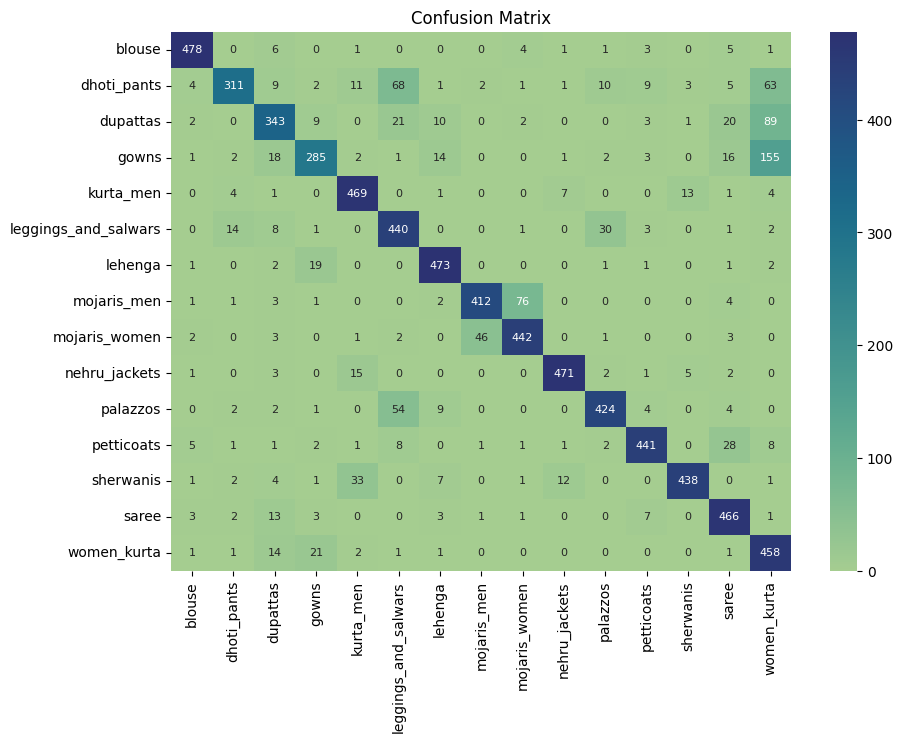

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plotting confusion matrix as heat map so that it is easier to read
df_cm = pd.DataFrame(cm, index = ['blouse', 'dhoti_pants', 'dupattas', 'gowns', 'kurta_men', 'leggings_and_salwars', 'lehenga', 'mojaris_men', 'mojaris_women', 'nehru_jackets', 'palazzos', 'petticoats', 'sherwanis', 'saree', 'women_kurta'],
                  columns = ['blouse', 'dhoti_pants', 'dupattas', 'gowns', 'kurta_men', 'leggings_and_salwars', 'lehenga', 'mojaris_men', 'mojaris_women', 'nehru_jackets', 'palazzos', 'petticoats', 'sherwanis', 'saree', 'women_kurta'])
plt.figure(figsize = (10,7))
_ = sns.heatmap(df_cm, annot=True, annot_kws={"size":8}, fmt='d', cmap='crest')
_ = plt.title('Confusion Matrix')